###Import

In [ ]:
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', None)
import os
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Load data

* Load *train_data.csv*, *products_data.csv* and *test_data.csv* using pandas.

In [ ]:
train_dataframes = []
for i in tqdm(range(1, 11)):
    train_dataframes.append(pd.read_csv(f'/content/gdrive/MyDrive/MLDM - Carrefour Project/data-train/train_data_part_{i}.csv'))
#train_dataframes.append(pd.read_csv(f'/content/gdrive/MyDrive/MLDM Carrefour Project/data-train/train_data_part_1.csv'))
#train_dataframes.append(pd.read_csv(f'/content/gdrive/MyDrive/Idk_MLDM_Project/train_data_part_9.csv'))
#train_dataframes.append(pd.read_csv(f'/content/gdrive/MyDrive/Idk_MLDM_Project/train_data_part_10.csv'))

train_data = pd.concat(train_dataframes, ignore_index=True)

del train_dataframes

products_data = pd.read_csv('/content/gdrive/MyDrive/MLDM - Carrefour Project/data-train/products_data.csv', low_memory=False)
test_data = pd.read_csv('/content/gdrive/MyDrive/MLDM - Carrefour Project/data-train/test_data.csv')

100%|██████████| 10/10 [02:19<00:00, 13.97s/it]


In [ ]:
columns_to_drop = [
    'product_description', 'regional_product', 'bio', 'porc', 'vegan',
    'department_key', 'class_key', 'subclass_key', 'sector', 'lactose_free',
    'brand_key', 'shelf_level1', 'shelf_level2', 'shelf_level3',
    'shelf_level4', 'ecoscore', 'local_french', 'naturality', 'fresh',
    'national_brand',  'first_price_brand', 'produits_du_monde',
    'casher', 'aspartame_free', 'sugar_free', 'gluten_free', 'frozen',
    'eco_friendly',  'artificial_coloring_free',  'taste_enhancer_free',
    'antibiotic_free', 'reduced_sugar', 'pesticide_free', 'grain_free', 'no_added_sugar',
    'salt_reduced', 'nitrite_free', 'fed_without_ogm', 'no_added_salt', 'no_artificial_flavours',
    'fat_free', 'reduced_fats', 'phenylalanine_free', 'palm_oil_free'
]
products_data = products_data.drop(columns=columns_to_drop)
columns_to_drop = ['store_id', 'format', 'order_channel', 'has_loyality_card', 'quantity']
train_data = train_data.drop(columns=columns_to_drop)

frequency_features = train_data.groupby(['customer_id', 'product_id']).size().reset_index(name='frequency')
train_data = pd.merge(train_data, frequency_features, on=['customer_id', 'product_id'], how='left')

train_data['date'] = pd.to_datetime(train_data['date'])
latest_date = train_data['date'].max()

train_data['recency'] = (latest_date - train_data['date']).dt.days

recency_features = train_data.groupby(['customer_id', 'product_id'])['recency'].min().reset_index()
recency_features.rename(columns={'recency': 'recency_calculated'}, inplace=True)
train_data = pd.merge(train_data, recency_features, on=['customer_id', 'product_id'], how='left')

scaler = MinMaxScaler()
if 'recency_calculated' in train_data.columns:
    train_data['recency_norm'] = scaler.fit_transform(train_data[['recency_calculated']])
else:
    raise ValueError("Recency column missing after merge.")
train_data['frequency_norm'] = scaler.fit_transform(train_data[['frequency']])
train_data['recency_norm'] = scaler.fit_transform(train_data[['recency']])

data_train = pd.merge(train_data, products_data, on="product_id", how="left")

data_train = data_train.sort_values(by='date')
data_train.reset_index(drop=True, inplace=True)
data_train = data_train.drop(columns=['date'])

# Caser

## Preprocess Data

In [ ]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87086626 entries, 0 to 87086625
Data columns (total 13 columns):
 #   Column              Dtype  
---  ------              -----  
 0   transaction_id      object 
 1   customer_id         object 
 2   product_id          object 
 3   is_promo            int64  
 4   frequency           int64  
 5   recency             int64  
 6   recency_calculated  int64  
 7   recency_norm        float64
 8   frequency_norm      float64
 9   halal               int64  
 10  vegetarian          int64  
 11  alcool              int64  
 12  carrefour_brand     int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 8.4+ GB


In [ ]:
# Parameters
max_seq_length = 20  # Maximum sequence length for Caser
val_ratio = 0.3  # Proportion of data for validation set

# Step 1: Drop missing values for essential features
data_train = data_train.dropna(subset=['customer_id', 'product_id'])

# Step 2: Normalize numerical features
numerical_cols = ['frequency', 'recency', 'recency_norm', 'frequency_norm']
scaler = MinMaxScaler()
data_train[numerical_cols] = scaler.fit_transform(data_train[numerical_cols])

# Step 3: Encode categorical features (`customer_id` and `product_id`)
customer_encoder = LabelEncoder()
product_encoder = LabelEncoder()
data_train['customer_id'] = customer_encoder.fit_transform(data_train['customer_id'])
data_train['product_id'] = product_encoder.fit_transform(data_train['product_id'])

# Step 4: Create sequences grouped by `customer_id`
customer_sequences = []
customer_features = []

for _, group in data_train.groupby('customer_id'):
    # Sort by `transaction_id` to ensure temporal order
    group = group.sort_values('transaction_id')

    # Extract product IDs
    product_ids = group['product_id'].tolist()

    # Extract feature columns
    feature_columns = ['is_promo', 'frequency', 'recency', 'recency_calculated',
                       'recency_norm', 'frequency_norm', 'halal', 'vegetarian',
                       'alcool', 'carrefour_brand']
    features = group[feature_columns].values  # Only keep relevant features

    # Truncate or pad sequences
    if len(product_ids) > max_seq_length:
        product_ids = product_ids[-max_seq_length:]
        features = features[-max_seq_length:]
    else:
        padding_length = max_seq_length - len(product_ids)
        product_ids = [0] * padding_length + product_ids
        features = np.vstack([np.zeros((padding_length, features.shape[1])), features])

    # Store sequences and features
    customer_sequences.append(product_ids)
    customer_features.append(features)

# Convert lists to NumPy arrays
X_sequences = np.array(customer_sequences)  # Shape: (num_customers, max_seq_length)
X_features = np.array(customer_features)    # Shape: (num_customers, max_seq_length, num_features)

# Step 5: Create input and target sequences
X_train_seq = X_sequences[:, :-1]   # Input sequence (all but the last item)
y_train_seq = X_sequences[:, -1]    # Target sequence (last item)
X_train_features = X_features[:, :-1, :]  # Features corresponding to input sequence

# Step 6: Train-validation split
X_train_seq, X_val_seq, X_train_features, X_val_features, y_train_seq, y_val_seq = train_test_split(
    X_train_seq, X_train_features, y_train_seq, test_size=val_ratio, random_state=42
)

# Step 7: Convert data to PyTorch tensors
X_train_seq = torch.tensor(X_train_seq, dtype=torch.long)        # Product IDs (input sequence)
y_train_seq = torch.tensor(y_train_seq, dtype=torch.long)        # Product IDs (target)
X_train_features = torch.tensor(X_train_features, dtype=torch.float32)  # Features (input sequence)

X_val_seq = torch.tensor(X_val_seq, dtype=torch.long)
y_val_seq = torch.tensor(y_val_seq, dtype=torch.long)
X_val_features = torch.tensor(X_val_features, dtype=torch.float32)

# Print shapes for verification
print(f"X_train_seq shape: {X_train_seq.shape}, X_train_features shape: {X_train_features.shape}, y_train_seq shape: {y_train_seq.shape}")
print(f"X_val_seq shape: {X_val_seq.shape}, X_val_features shape: {X_val_features.shape}, y_val_seq shape: {y_val_seq.shape}")

X_train_seq shape: torch.Size([70000, 19]), X_train_features shape: torch.Size([70000, 19, 10]), y_train_seq shape: torch.Size([70000])
X_val_seq shape: torch.Size([30000, 19]), X_val_features shape: torch.Size([30000, 19, 10]), y_val_seq shape: torch.Size([30000])


## Train Caser

In [ ]:
class Caser(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim, max_seq_length, num_h_filters, num_v_filters, horizontal_filter_sizes, feature_dim):
        super(Caser, self).__init__()
        self.embedding_user = nn.Embedding(num_users, embedding_dim)
        self.embedding_item = nn.Embedding(num_items, embedding_dim)
        self.feature_dim = feature_dim

        # Horizontal convolutional layers
        self.horizontal_convs = nn.ModuleList([
            nn.Conv2d(1, num_h_filters, (k, embedding_dim + feature_dim)) for k in horizontal_filter_sizes
        ])
        self.horizontal_filter_sizes = horizontal_filter_sizes
        self.num_h_filters = num_h_filters

        # Vertical convolutional layer
        self.num_v_filters = num_v_filters
        self.vertical_conv = nn.Conv2d(1, num_v_filters, (max_seq_length, 1))

        # Fully connected layers
        combined_dim = num_h_filters * len(horizontal_filter_sizes) + num_v_filters
        self.fc1 = nn.Linear(combined_dim, 50)
        self.fc2 = nn.Linear(50, num_items)

    def forward(self, user_ids, item_seq, item_features):
        # Clamp user_ids to avoid out-of-range errors
        user_ids = torch.clamp(user_ids, 0, self.embedding_user.num_embeddings - 1)

        user_emb = self.embedding_user(user_ids).unsqueeze(1)  # (batch_size, 1, embedding_dim)
        item_seq = item_seq[:, 1:]  # Align sequence with features
        item_emb = self.embedding_item(item_seq)  # (batch_size, seq_length - 1, embedding_dim)

        # Truncate or align item_features
        if item_emb.shape[1] != item_features.shape[1]:
            item_features = item_features[:, :item_emb.shape[1], :]

        # Concatenate embeddings and features
        combined_input = torch.cat([item_emb, item_features], dim=2)  # (batch_size, seq_length - 1, embedding_dim + feature_dim)
        combined_input = combined_input.unsqueeze(1)  # (batch_size, 1, seq_length - 1, embedding_dim + feature_dim)

        # Horizontal convolution
        h_outputs = [
            torch.relu(conv(combined_input)).squeeze(3).view(combined_input.size(0), -1)
            for conv in self.horizontal_convs
        ]
        h_out = torch.cat(h_outputs, dim=1)

        # Vertical convolution (adjust dynamically)
        seq_length = combined_input.shape[2]
        if self.vertical_conv is None or self.vertical_conv.kernel_size[0] != seq_length:
            self.vertical_conv = nn.Conv2d(1, self.num_v_filters, (seq_length, 1)).to(combined_input.device)

        v_out = torch.relu(self.vertical_conv(combined_input)).view(combined_input.size(0), -1)

        # Combine horizontal and vertical outputs
        combined_output = torch.cat([h_out, v_out], dim=1)

        # Fully connected layers
        if self.fc1 is None or self.fc1.in_features != combined_output.size(1):
            self.fc1 = nn.Linear(combined_output.size(1), 50).to(combined_input.device)
            self.fc2 = nn.Linear(50, self.embedding_item.num_embeddings).to(combined_input.device)

        x = torch.relu(self.fc1(combined_output))
        scores = self.fc2(x)
        return scores

In [ ]:
# Combine sequences and features into a dataset
X_train_tensor = torch.tensor(X_train_seq, dtype=torch.long)  # Item sequences
X_train_features_tensor = torch.tensor(X_train_features, dtype=torch.float32)  # Features
y_train_tensor = torch.tensor(y_train_seq, dtype=torch.long)  # Targets

X_val_tensor = torch.tensor(X_val_seq, dtype=torch.long)
X_val_features_tensor = torch.tensor(X_val_features, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_seq, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, X_train_features_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, X_val_features_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Define model parameters
num_users = len(customer_encoder.classes_)
num_items = len(product_encoder.classes_)
embedding_dim = 50
feature_dim = X_train_features_tensor.size(2)
max_seq_length = X_train_seq.size(1)
num_h_filters = 16
num_v_filters = 8
horizontal_filter_sizes = [2, 3, 4]

# Initialize model
model = Caser(
    num_users=num_users,
    num_items=num_items,
    embedding_dim=embedding_dim,
    max_seq_length=max_seq_length,
    num_h_filters=num_h_filters,
    num_v_filters=num_v_filters,
    horizontal_filter_sizes=horizontal_filter_sizes,
    feature_dim=feature_dim,
)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

train_losses = []
val_losses = []
val_accuracies = []

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    train_loss = 0

    for user_seq, features, targets in train_loader:
        optimizer.zero_grad()

        # Extract user IDs and item sequences
        user_ids = user_seq[:, 0]  # User IDs from the first column
        item_seq = user_seq[:, 1:]  # Item sequences

        # Clamp to valid ranges
        user_ids = torch.clamp(user_ids, 0, num_users - 1)
        item_seq = torch.clamp(item_seq, 0, num_items - 1)

        # Forward pass
        scores = model(user_ids, item_seq, features)

        # Compute loss
        loss = criterion(scores, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    # Validation phase
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for user_seq, features, targets in val_loader:
            user_ids = user_seq[:, 0]
            item_seq = user_seq[:, 1:]
            scores = model(user_ids, item_seq, features)

            loss = criterion(scores, targets)
            val_loss += loss.item()

            _, predicted = torch.max(scores, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

    val_loss /= len(val_loader)
    val_accuracy = correct / total

    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

<ipython-input-7-abed1897fd61>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(X_train_seq, dtype=torch.long)  # Item sequences
<ipython-input-7-abed1897fd61>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_features_tensor = torch.tensor(X_train_features, dtype=torch.float32)  # Features
<ipython-input-7-abed1897fd61>:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train_seq, dtype=torch.long)  # Targets
<ipython-input-7-abed1897fd61>:6: UserWarning: To copy construc

Epoch 1/10, Train Loss: 11.5974, Val Loss: 11.5256, Val Accuracy: 0.0000
Epoch 2/10, Train Loss: 11.5045, Val Loss: 11.5179, Val Accuracy: 0.0000
Epoch 3/10, Train Loss: 11.4791, Val Loss: 11.5073, Val Accuracy: 0.0000
Epoch 4/10, Train Loss: 11.4556, Val Loss: 11.5029, Val Accuracy: 0.0000
Epoch 5/10, Train Loss: 11.4244, Val Loss: 11.5091, Val Accuracy: 0.0000
Epoch 6/10, Train Loss: 11.3862, Val Loss: 11.5178, Val Accuracy: 0.0000
Epoch 7/10, Train Loss: 11.3432, Val Loss: 11.5308, Val Accuracy: 0.0001
Epoch 8/10, Train Loss: 11.2952, Val Loss: 11.5450, Val Accuracy: 0.0000
Epoch 9/10, Train Loss: 11.2418, Val Loss: 11.5613, Val Accuracy: 0.0000
Epoch 10/10, Train Loss: 11.1848, Val Loss: 11.5812, Val Accuracy: 0.0000


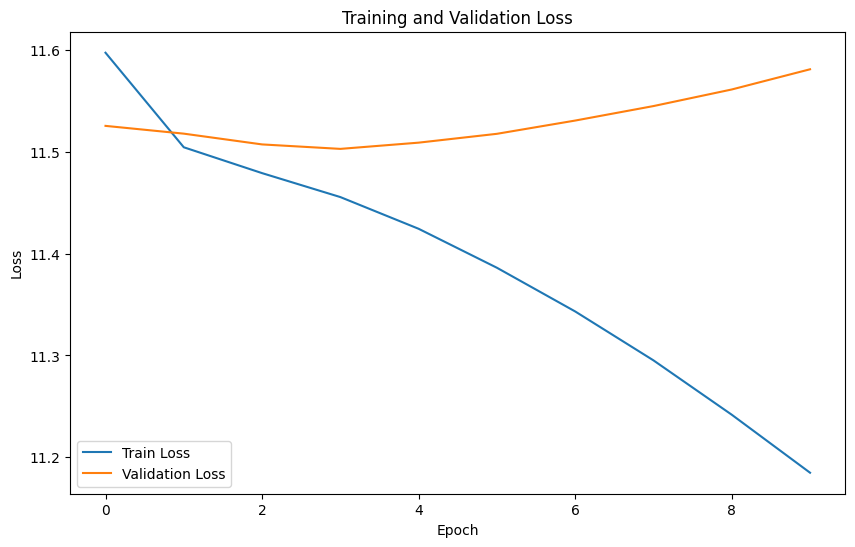

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

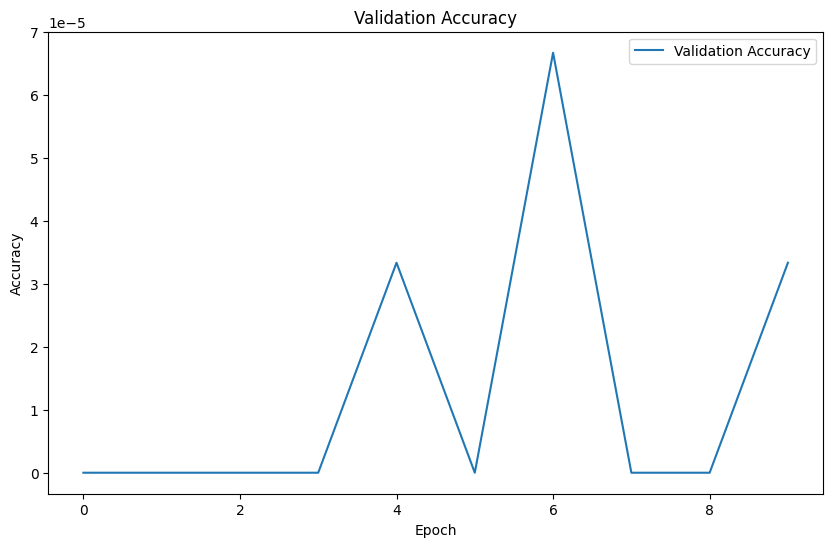

In [ ]:
# Plot validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

## Evaluate Caser

In [ ]:
user_item_history = train_data.groupby('customer_id')['product_id'].apply(list).to_dict()

def create_product_id_mapping(user_item_history):
    """
    Create a mapping from product_id (string) to an integer.
    """
    unique_product_ids = set([product_id for seq in user_item_history.values() for product_id in seq])
    product_id_mapping = {product_id: idx for idx, product_id in enumerate(unique_product_ids)}
    return product_id_mapping

def pad_sequences(user_item_history, num_items, product_id_mapping, device='cpu'):
    # Pad sequences to a minimum length and convert product_ids to integers
    padded_sequences = {}
    for user_id, seq in user_item_history.items():
        # Convert product IDs to integers using the mapping
        seq = [product_id_mapping.get(product_id, -1) for product_id in seq]  # -1 for unknown product_ids

        if len(seq) < num_items:  # Pad if sequence length is smaller
            pad_length = num_items - len(seq)
            seq = seq + [0] * pad_length  # Padding with 0
        padded_sequences[user_id] = torch.tensor(seq, dtype=torch.long).to(device)

    return padded_sequences

# Create product ID mapping
product_id_mapping = create_product_id_mapping(user_item_history)

# Apply padding to user-item history with the mapping
padded_user_item_history = pad_sequences(user_item_history, num_items, product_id_mapping, device='cpu')

def generate_top_10_recommendations(model, train_data, item_features, num_users, num_items, product_id_mapping, device='cpu'):
    """
    Generate top 10 recommendations for each user from the trained Caser model.

    Args:
        model: Trained Caser model.
        train_data: DataFrame containing historical transaction data.
        item_features: Tensor containing product features.
        num_users: Total number of users in the dataset.
        num_items: Total number of items in the dataset.
        product_id_mapping: Mapping from product_id (str) to integer index.
        device: Device to run the model on (e.g., 'cpu' or 'cuda').

    Returns:
        DataFrame with columns: 'customer_id', 'product_id', 'rank'.
    """
    model.eval()  # Set the model to evaluation mode

    # Create user-item history from transaction data
    user_item_history = train_data.groupby('customer_id')['product_id'].apply(list).to_dict()

    # Pad sequences for each user
    padded_user_item_history = pad_sequences(user_item_history, num_items, product_id_mapping, device=device)

    recommendations = []

    for user_id in range(num_users):
        # Get padded item sequence for the user
        item_seq = padded_user_item_history.get(user_id, torch.zeros(num_items, dtype=torch.long).to(device))

        # Prepare user IDs
        user_ids = torch.tensor([user_id] * num_items, dtype=torch.long).to(device)

        # Pass item features into the model
        features = item_features.unsqueeze(0).to(device)  # Add batch dimension
        scores = model(user_ids, item_seq.unsqueeze(0), features).detach().cpu().numpy().flatten()

        # Get top 10 recommendations
        top_10_item_indices = scores.argsort()[-10:][::-1]

        for rank, item_idx in enumerate(top_10_item_indices, start=1):
            recommendations.append({
                'customer_id': user_id,
                'product_id': item_idx,
                'rank': rank
            })

    return pd.DataFrame(recommendations)

product_features = (
    data_train.drop_duplicates(subset='product_id')  # Keep one row per product_id
    .set_index('product_id')  # Use product_id as the index
    .select_dtypes(include=['number'])  # Select only numeric columns for features
    .to_numpy()
)
item_features = torch.tensor(product_features, dtype=torch.float)

top_10_recommendations = generate_top_10_recommendations(model, train_data, item_features, num_users, num_items, product_id_mapping, device='cpu')

In [ ]:
def hitrate_at_k(true_data: pd.DataFrame, predicted_data: pd.DataFrame, k: int = 10) -> float:
    """
    This function calculates the hitrate at k for the recommendations.
    It assesses how relevant our 10 product recommendations are.
    Args:
        true_data: True product purchase data
        predicted_data: Predicted product recommendations
        k: The number of top recommendations to consider
    Returns:
        The hitrate at k
    """
    # Ensure customer_id columns are strings before extracting numeric part (if needed)
    true_data['customer_id'] = true_data['customer_id'].astype(str)
    predicted_data['customer_id'] = predicted_data['customer_id'].astype(str)

    # Option 1: Extract numeric customer_id from strings if needed
    true_data['customer_id'] = true_data['customer_id'].str.extract('(\d+)', expand=False).astype(int)
    predicted_data['customer_id'] = predicted_data['customer_id'].str.extract('(\d+)', expand=False).astype(int)

    # Ensure product_id columns are strings before extracting numeric part
    true_data['product_id'] = true_data['product_id'].astype(str)
    predicted_data['product_id'] = predicted_data['product_id'].astype(str)

    # Extract numeric part from product_id and convert to integers
    true_data['product_id'] = true_data['product_id'].str.extract('(\d+)', expand=False).astype(int)
    predicted_data['product_id'] = predicted_data['product_id'].str.extract('(\d+)', expand=False).astype(int)

    # Merge the true and predicted data on customer_id and product_id
    data = pd.merge(left=true_data, right=predicted_data, how="left", on=["customer_id", "product_id"])

    # Filter recommendations where rank <= k
    df = data[data["rank"] <= k]

    # Calculate the number of successful recommendations per user
    non_null_counts = df.groupby('customer_id')['rank'].apply(lambda x: x.notna().sum()).reset_index(name='non_null_count')

    # Calculate the hitrate as the ratio of successful recommendations
    total_users = len(true_data['customer_id'].unique())
    hitrate = non_null_counts['non_null_count'].sum() / (total_users * k)

    return hitrate

# Calculate hitrate@10 with the updated function
hitrate_at_10 = hitrate_at_k(test_data, top_10_recommendations, k=10)
print(f"Hitrate@10 for the model is {hitrate_at_10:.2f}")

Hitrate@10 for the model is 0.00
